In [7]:
import itertools
import logging
import os
import pickle
import textwrap
import traceback
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import librosa
import numpy as np
from tqdm import tqdm

USE_GPU = False

if USE_GPU:
    import manage_gpus as gpl

    gpl.get_gpu_lock()
import activation_learner
import pytorch_nmf
import param_estimator
import plot
from unmixdb import UnmixDB
from multiprocessing import Lock


In [8]:

# UNMIXDB_PATH = Path("/data2/anasynth_nonbp/andre/unmixdb-zenodo")
UNMIXDB_PATH = Path("/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/")
unmixdb = UnmixDB(UNMIXDB_PATH)
GAIN_ESTOR = param_estimator.GainEstimator.SUM
WARP_ESTOR = param_estimator.WarpEstimator.CENTER_OF_MASS
LOG_NMF_EVERY = 100
DLOSS_MIN = -np.inf
ITER_MAX = 500
FS = 22050
MIX_NAME = "set044mix3-none-none-03.mp3"


logger = logging.getLogger(MIX_NAME)
logging.basicConfig()
logger.setLevel(logging.DEBUG)

mix = unmixdb.mixes[MIX_NAME]
input_paths = [unmixdb.refsongs[track["name"]].audio_path for track in mix.tracks] + [
    mix.audio_path
]
pprint(input_paths)

# load audios
inputs = [librosa.load(path, sr=FS)[0] for path in input_paths]

[PosixPath('/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/mixotic-set044-excerpts/refsongs/pntg001-05-kairos-no_more_acid.excerpt40.mp3'),
 PosixPath('/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/mixotic-set044-excerpts/refsongs/pntg001-06-liam_o_leary_and_heyden-rock_the_boat.excerpt40.mp3'),
 PosixPath('/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/mixotic-set044-excerpts/refsongs/pntg001-07-mabik-deep_house.excerpt40.mp3'),
 PosixPath('/data2/anasynth_nonbp/schwarz/abc-dj/data/unmixdb-zenodo/mixotic-set044-excerpts/mixes/set044mix3-none-none-03.mp3')]


/tmp/ipykernel_30071/2561587826.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  inputs = [librosa.load(path, sr=FS)[0] for path in input_paths]
/data/anasynth_nonbp/manaconda3/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_30071/2561587826.py:24: UserWarning: PySoundFile failed. Trying audioread instead.
  inputs = [librosa.load(path, sr=FS)[0] for path in input_paths]
/data/anasynth_nonbp/manaconda3/lib/python3.9/site-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/tmp/ipykernel_30071/2561587826.py:24: UserWarning: PySoundFile failed. Trying audioread inste

INFO:set044mix3-none-none-03.mp3:Starting round with hop_size=0.5s, win_size=2.0s
INFO:set044mix3-none-none-03.mp3:Running NMF on V:torch.Size([128, 214]), W:torch.Size([128, 287]), H:torch.Size([287, 214])
100%|██████████| 500/500 [00:07<00:00, 70.03it/s]


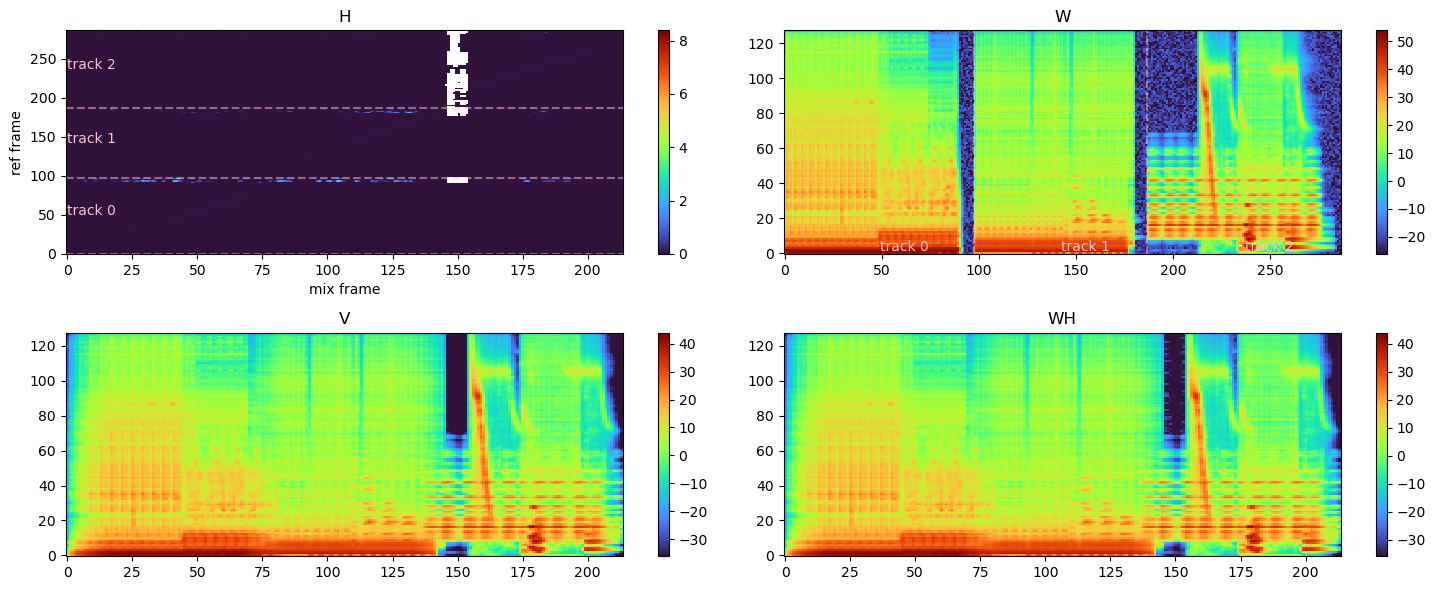

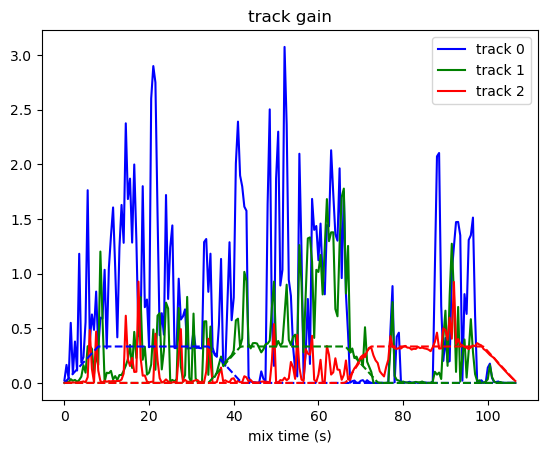

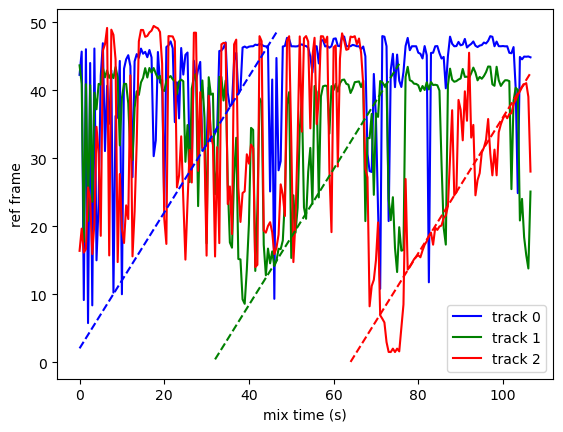

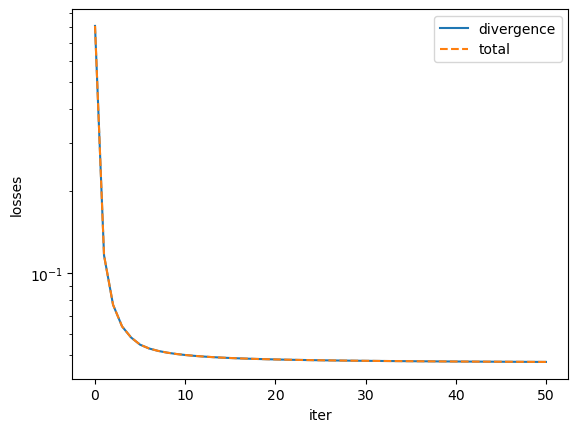

In [9]:


hop_size = 0.5

overlap = 4
win_size = hop_size * overlap
nmels = 128
noise_floor = 0.01
divergence = pytorch_nmf.ItakuraSaito()
penalties = []

logger.info(f"Starting round with {hop_size=}s, {win_size=}s")

learner = activation_learner.ActivationLearner(
    inputs,
    fs=FS,
    n_mels=nmels,
    win_size=win_size,
    hop_size=hop_size,
    penalties=penalties,
    divergence=divergence,
    noise_floor=noise_floor,
    use_gpu=USE_GPU,
)
#################
# iterate
logger.info(
    f"Running NMF on V:{learner.nmf.V.shape}, W:{learner.nmf.W.shape}, H:{learner.nmf.H.shape}"
)
loss_history = []
loss = np.inf
for i in tqdm(itertools.count(), total=ITER_MAX):
    learner.iterate()
    if i % 10 == 0:
        loss, loss_components = learner.loss()
        loss_history.append(loss_components)

        if i >= ITER_MAX:
            logger.info(f"Stopped at NMF iteration={i} loss={loss}")
            break
#############
# estimations

# get ground truth
tau = np.arange(0, learner.V.shape[1]) * hop_size
real_gain = mix.get_track_gain(tau)
real_warp = mix.get_track_warp(tau)

# estimate gain
est_gain = GAIN_ESTOR(learner)
err_gain = param_estimator.error(est_gain, real_gain)

# estimate warp
est_warp = WARP_ESTOR(learner, hop_size)
err_warp = param_estimator.error(est_warp, real_warp)

###################
# plots
plot.plot_nmf(learner)
plt.show()

fig = plt.figure()
plot.plot_gain(tau, est_gain, real_gain)
plt.show()

fig = plt.figure()
plot.plot_warp(tau, est_warp, real_warp)
plt.show()
fig = plt.figure()
plot.plot_loss_history(loss_history)
plt.show()